# Import packages

In [1070]:
import re
import requests
import pprint
import urllib.error, urllib.parse, urllib.request
from bs4 import BeautifulSoup as bs 
import os
from collections import Counter
import glob

import argparse

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer # very good tokenizer for english, considers sentence structure
from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

## Suppress future warnings

In [980]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Argparse - to do

In [ ]:

'''
TO DO:

* arguments
    - artist
    - max downloads: 30 songs
    - option to type some words for prediction 
    - option: do you want to see the plot? 
    - 


""" Program to download lyrics
"""

import argparse

parser = argparse.ArgumentParser(description = _doc_, epilog = 'some final remarks')

parser.add_argument("artist", help="Please enter the name of the artist. First letter capitalized", type=str)
parser.add_argument("number", help="Enter the page to download lyrics from: ('https://www.lyrics.com')", type=str)
parser.add_argument("--like", help="How do you like the artist at all?")


args = parser.parse_args()

artist = args.artist
n_songs = args.number[0]

print(f"{artist} created {n_songs} songs.")

'''

# Declare constants

In [680]:
artist = 'Dido'

In [682]:
url = (f'https://www.lyrics.com/artist/{artist}')

In [683]:
url

'https://www.lyrics.com/artist/Dido'

In [684]:
lyric_url = 'https://www.lyrics.com'

In [685]:
print(os.getcwd())
parent_dir = os.getcwd()
artist_path = (os.path.join(f'{parent_dir}/{artist.lower()}'))


/Users/ilonanietosvaara/Documents/Kurssit/spiced/spiced_projects/scikit-cilantro-student-code/week_04/project_w4


In [686]:
print(artist_path)

/Users/ilonanietosvaara/Documents/Kurssit/spiced/spiced_projects/scikit-cilantro-student-code/week_04/project_w4/dido


# All functions

#### Request html text from artist page

In [378]:
def html_request(link):
    return urllib.request.urlopen(link).read()

#### Parse all links from artist page html

In [379]:
def souptags(htmltext):
    soup = bs(html, 'html.parser') 
    tags = soup('a')
    for t in tags:
        #print(t.get('href', None))
        urls.append(t.get('href', None)) 

#### Filter out non-song lyric links

In [380]:
def filter_songs(filt_regex, songlist):
    return list(filter(re.compile(filt_regex).match, songlist))
    

#### Create full link to each lyric link 

In [381]:
def songlinks(links):
    for song in links:
        song_links.append(lyric_url + song)
        
    return song_links

#### Write all song links to a text file

In [382]:
def songs_to_file(file, links):
    with open(file, 'w') as f:
        for counter, song in enumerate(links):
            print(counter, song)
            titles.append(song.split('/')[-1])
            f.write(song+'\n')

#### Parse lyrics from each lyrics link html and save to separate text files

In [383]:
def links_to_list(links): 
    for counter, link in enumerate(links):
        url = link
        lyric_html = (urllib.request.urlopen(url).read())
        soup_h = bs(lyric_html, 'html.parser')
        lyric_clean = str([t.text for t in soup_h.find_all(attrs={'class': 'lyric-body'})])
        song_title = link.split('/')[6]
        with open(f'{artist_path}/{song_title}.txt', 'w') as f:
            f.write(lyric_clean)
        print(counter, song_title)

#### Append lyric text to corpus list var

In [384]:
def lyrics_to_file(artist_path):
    for fn in os.listdir(f'{artist_path}'):
   # print(fn)
        if 'txt' in fn:
            text = open(f'{artist_path}/{fn}').read()
            text = text.replace('\\n',' ') 
            text = text.replace('\\r',' ') 
            corpus.append(text)
            titles.append(fn)
        else:
            print(f'==========={fn} is not a text file=================')

#### Create dataframe out of the lyrics and titles

In [385]:
def make_dataframe(corpus, titles):
    d = {'lyrics': corpus, 'title': titles}
    df = pd.DataFrame(d)
    df['artist'] = artist.lower()
    df.to_csv(f'{artist}_songs.csv', sep='\t')
    return df

#### Clean the string in lyrics and titles

In [1172]:
def cleaning(df):
    df['lyrics'] = df['lyrics'].str.lower().str.replace('?', '').str.replace("(", '').str.replace(')', '').str.replace(',', '').str.replace(".", '').str.replace("/.", '').str.replace("*", '').str.replace("!", '').str.replace(":", '').str.replace(";", '').str.replace("&", '').str.replace("-", '').str.replace("/", '').str.replace("\\", '').str.replace("`", '') 
    df['title'] = df['title'].str.lower().str.replace('\n', ' ').str.replace('\r', '').str.replace('\'', '').str.replace('?', '').str.replace('+', ' ').str.replace(')', '').str.replace('%.+', '').str.replace('.txt', '')
    #df['lyrics']= df['lyrics'].str.replace("'", '', regex=True)
    return df
#.str.replace("/'", '')

#### Drop duplicate songs by title

In [688]:
def drop_duplicate_songs(df):
    df = df.drop_duplicates(subset='title', keep="first")
    df = df.reset_index(drop=True)
    return df

#### Remove digits from the string

In [689]:
def remove_digits(df):
    df['lyrics'] = df['lyrics'].str.replace(r'[^\D]+', '')
    return df

# All empty lists

In [79]:
urls = []


In [80]:
song_links = []

In [81]:
songfile = f'{artist}songs.txt'
titles = []

In [97]:
corpus = []
titles = []

# Calling all functions


In [82]:
html = html_request(url)

In [84]:
souptags(html)

In [86]:
urls = filter_songs('^((?!version|live|Live|5D|Remix|Edit|Rehearsal).)*$', urls)
urls = filter_songs(f"/lyric/\d+/{artist}/.+", urls)

In [88]:
song_links = songlinks(urls)

In [89]:
songs_to_file(songfile, song_links)

0 https://www.lyrics.com/lyric/36604185/Dido/Just+Because
1 https://www.lyrics.com/lyric/36341926/Dido/7+Seconds
2 https://www.lyrics.com/lyric/36262718/Dido/Hurricanes
3 https://www.lyrics.com/lyric/35955572/Dido/Give+You+Up
4 https://www.lyrics.com/lyric/35955571/Dido/Hell+After+This
5 https://www.lyrics.com/lyric/35955570/Dido/You+Don%27t+Need+a+God
6 https://www.lyrics.com/lyric/35955569/Dido/Take+You+Home
7 https://www.lyrics.com/lyric/35955568/Dido/Some+Kind+of+Love
8 https://www.lyrics.com/lyric/35955567/Dido/Still+on+My+Mind
9 https://www.lyrics.com/lyric/35955566/Dido/Mad+Love
10 https://www.lyrics.com/lyric/35955565/Dido/Walking+By
11 https://www.lyrics.com/lyric/35955564/Dido/Friends
12 https://www.lyrics.com/lyric/35955563/Dido/Chances
13 https://www.lyrics.com/lyric/35955562/Dido/Have+to+Stay
14 https://www.lyrics.com/lyric/35027802/Dido/Life+for+Rent
15 https://www.lyrics.com/lyric/35805563/Dido/Christmas+Day
16 https://www.lyrics.com/lyric/34870533/Dido/Here+With+Me
17 h

In [91]:
links_to_list(song_links)

0 Just+Because
1 7+Seconds
2 Hurricanes
3 Give+You+Up
4 Hell+After+This
5 You+Don%27t+Need+a+God
6 Take+You+Home
7 Some+Kind+of+Love
8 Still+on+My+Mind
9 Mad+Love
10 Walking+By
11 Friends
12 Chances
13 Have+to+Stay
14 Life+for+Rent
15 Christmas+Day
16 Here+With+Me
17 Sand+in+My+Shoes
18 Here+With+Me
19 Here+With+Me
20 Here+With+Me
21 Christmas+Day
22 White+Flag
23 Beside+the+Sea
24 Thank+You
25 Thank+You
26 Christmas+Day
27 One+Step+Too+Far
28 Feelin%27+Good
29 Thank+You
30 Thank+You
31 Here+with+Me
32 Christmas+Day
33 Christmas+Day
34 Christmas+Day
35 Stan
36 White+Flag
37 Thank+You
38 White+Flag
39 White+Flag
40 White+Flag
41 Thank+You
42 White+Flag
43 No+Freedom
44 Girl+Who+Got+Away
45 Let+Us+Move+On
46 Blackbird
47 End+of+Night
48 Sitting+on+the+Roof+of+the+World
49 Love+to+Blame
50 Go+Dreaming
51 Happy+New+Year
52 Loveless+Hearts
53 Day+Before+We+Went+to+War
54 No+Freedom
55 Girl+Who+Got+Away
56 Let+Us+Move+On
57 Blackbird
58 End+of+Night
59 Sitting+on+the+Roof+of+the+World
60 Lov

486 Together+%28In+These+Times%29
487 Hurricanes
488 Stan
489 Northern+Skies
490 One+Step+Too+Far
491 Stan
492 Sand+in+My+Shoes
493 One+Step+Too+Far
494 Don%27t+Leave+Home
495 Thank+You
496 Isobel
497 One+Step+Too+Far
498 Don%27t+Leave+Home
499 Thank+You
500 One+Step+Too+Far
501 One+Step+Too+Far
502 One+Step+Too+Far
503 One+Step+Too+Far
504 One+Step+Too+Far
505 Burnin%27+Love+%28feat.+Citizen+Cope%29
506 Just+Because
507 Let+Us+Move+On
508 Friends
509 Sand+in+My+Shoes
510 Sand+in+My+Shoes
511 Thank+You


In [1173]:
lyrics_to_file(artist_path)

In [1174]:
corpus[:1]

['["I want the view from the top of the hill  Give me the view from the top of the hill    When I think of you  And your good life  And your sorrow too  How much I\'m missing you  No matter where I go  Or where I come to stay  This is waking up  I want this feeling  Doors wide open    And now I leave it all  Bags of trouble  And a messy mind  Oh I hope I find  Where your load is light  Where your heart\'s at ease  This is waking up  And feeling good, feeling good    Hey, I\'m making my mistakes  \'Cause I\'m no great shakes at being perfect  I just take my breaks and work it  Bring it to the surface  Like a scuba diver  Never nervous  Cause now I\'m older and wiser  An\' I\'ve a bold feelin\'  This old skin is peeln\'  Revealing a new layer  I\'m no soothsayer  But I feel it\'s time to leave  To polish my heart with the other sleeve    I want the view from the top of the hill  Give me the view from the top of the hill  I want the view from the top of the hill  Give me the view from the

In [1175]:
titles[:5]

['Feelin%27+Good.txt',
 'Hunter.txt',
 'See+the+Sun.txt',
 'Go+Dreaming.txt',
 'The+Hunter.txt']

In [1176]:
df = make_dataframe(corpus, titles)

In [1177]:
specialChars = "]" 
for count, lyric in enumerate(df['lyrics']):
    for specialChar in specialChars:
        lyric_new = lyric.replace(specialChar, '')
        df["lyrics"][count] = lyric_new

In [1178]:
specialChars = "["
for count, lyric in enumerate(df['lyrics']):
    for specialChar in specialChars:
        lyric_new = lyric.replace(specialChar, '')
        df["lyrics"][count] = lyric_new

In [1179]:
specialChars = '/"' 
for count, lyric in enumerate(df['lyrics']):
    for specialChar in specialChars:
        lyric_new = lyric.replace(specialChar, '')
        df["lyrics"][count] = lyric_new

In [1180]:
df = cleaning(df)

In [1181]:
df = drop_duplicate_songs(df)

In [1182]:
df = remove_digits(df)

In [1183]:
df.to_csv(f'{artist}_bysong_clean.csv', sep='\t')

In [1184]:
df = pd.read_csv(f'{artist}_bysong_clean.csv', sep='\t', index_col = [0])

In [1185]:
df.head(2)

,lyrics,title,artist
0,i want the view from the top of the hill give me the view from the top of the hill when i think of you and your good life and your sorrow too how much i'm missing you no matter where i go or where i come to stay this is waking up i want this feeling doors wide open and now i leave it all bags of trouble and a messy mind oh i hope i find where your load is light where your heart's at ease this is waking up and feeling good feeling good hey i'm making my mistakes 'cause i'm no great shakes at being perfect i just take my breaks and work it bring it to the surface like a scuba diver never nervous cause now i'm older and wiser an' i've a bold feelin' this old skin is peeln' revealing a new layer i'm no soothsayer but i feel it's time to leave to polish my heart with the other sleeve i want the view from the top of the hill give me the view from the top of the hill i want the view from the top of the hill give me the view from the top of the hill and feeling good feeling good,feelin,dido
1,with one light on in one room i know you're up when i get home with one small step upon the stair i know your look when i get there if you were a king up there on your throne would you be wise enough to let me go for this queen you think you own wants to be a hunter again i want to see the world alone again to take a chance on life again so let me go the unread book and painful look the tv's on the sound is down one long pause then you begin oh look what the cat's brought in if you were a king up there on your throne would you be wise enough to let me go for this queen you think you own wants to be a hunter again i want to see the world alone again to take a chance on life again so let me go let me leave for the crown you've placed upon my head feels too heavy now and i don't know what to say to you but i'll smile anyhow and all the time i'm thinking thinking i want to be a hunter again i want to see the world alone again to take a chance on life again so let me go i want to be a hunter again i want to see the world alone again to take a chance on life again so let me go let me leave let me go,hunter,dido


# Combine dataframes

In [1186]:
df_muse = pd.read_csv('muse_bysong_clean.csv', sep='\t', index_col = [0])

In [1187]:
df_dido = pd.read_csv(f'{artist}_bysong_clean.csv', sep='\t', index_col = [0])

In [1188]:
df_muse.head(2)

,lyrics,title,artist
0,take me for a ride break me up and steal whats left inside and make them pray the iniquity has died inside and left a scar im all red and done bring me peace and wash away my dirt spin me round and have me to divert and walk into the light warm my heart to remind and hold my head up high and help me to survive kick me when im down feed me poison for me till i drown wake me up before i get ṗunched out and fall into the night warm my heart to remind and hold my head up high and help me to survive,liquid state,muse
1,stay wait for me build a fortress and shield your beliefs touch the divide as we fall in the ravine cant believe when i dont trust all your theories turn to dust a truth to hide from you seeing red destroy this city of delusion break these walls down why do we face justify my reasons with your bloody hand you will not rest settle for less until you guzzle and squander whats left do not deny where you live and led alone destroy this city of delusion break these walls down why do we face justify my reasons with your bloody hand destroy this city of delusion break these walls down why do we face justify my reasons with your bloody hand,city of delusion,muse


In [1189]:
df_dido.head(2)

,lyrics,title,artist
0,i want the view from the top of the hill give me the view from the top of the hill when i think of you and your good life and your sorrow too how much i'm missing you no matter where i go or where i come to stay this is waking up i want this feeling doors wide open and now i leave it all bags of trouble and a messy mind oh i hope i find where your load is light where your heart's at ease this is waking up and feeling good feeling good hey i'm making my mistakes 'cause i'm no great shakes at being perfect i just take my breaks and work it bring it to the surface like a scuba diver never nervous cause now i'm older and wiser an' i've a bold feelin' this old skin is peeln' revealing a new layer i'm no soothsayer but i feel it's time to leave to polish my heart with the other sleeve i want the view from the top of the hill give me the view from the top of the hill i want the view from the top of the hill give me the view from the top of the hill and feeling good feeling good,feelin,dido
1,with one light on in one room i know you're up when i get home with one small step upon the stair i know your look when i get there if you were a king up there on your throne would you be wise enough to let me go for this queen you think you own wants to be a hunter again i want to see the world alone again to take a chance on life again so let me go the unread book and painful look the tv's on the sound is down one long pause then you begin oh look what the cat's brought in if you were a king up there on your throne would you be wise enough to let me go for this queen you think you own wants to be a hunter again i want to see the world alone again to take a chance on life again so let me go let me leave for the crown you've placed upon my head feels too heavy now and i don't know what to say to you but i'll smile anyhow and all the time i'm thinking thinking i want to be a hunter again i want to see the world alone again to take a chance on life again so let me go i want to be a hunter again i want to see the world alone again to take a chance on life again so let me go let me leave let me go,hunter,dido


In [1190]:
df_full = df_dido.append(df_muse)

In [1191]:
df_full.dropna(inplace=True)

In [1192]:
df_full = df_full.reset_index(drop=True)

In [1193]:
df_full = df_full.join(pd.get_dummies(df_full['artist'], drop_first=True))

In [1194]:
df_full.head(1), df_full.tail(1)

(                                              lyrics   title artist  muse
 0  i want the view from the top of the hill  give...  feelin   dido     0,
                                                 lyrics                title  \
 216  lips are turning blue  a kiss that cant renew ...  sing for absolution   
 
     artist  muse  
 216   muse     1  )

In [1195]:
df_full.to_csv('full_bysong_clean.csv', sep='\t')

## Word cloud for muse

In [1228]:
df_muse.dropna(inplace=True)

In [1229]:
text_muse = " ".join(rew for rew in df_muse.lyrics)

In [1230]:
stopwords = set(STOPWORDS)
stopwords.update(['cant', 'will', 'youre', 'know', 'im', 'ill', 'dont', 'now'])

In [1231]:
wordcloud = WordCloud(background_color="white", stopwords = stopwords).generate(text_muse)

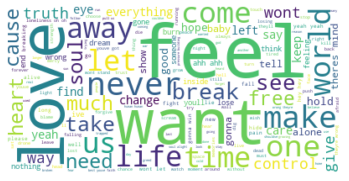

In [1232]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## World cloud for Dido

In [1225]:
stopwords = set(STOPWORDS)
stopwords.update(['cant', 'will', 'youre', 'know', 'im', 'ill', 'dont', 'now'])

In [1226]:
stopwords_o = 'cant', 'will', 'youre'
df_dido.dropna(inplace=True)
text_dido = " ".join(rew for rew in df_dido.lyrics)
wordcloud = WordCloud(background_color="white", stopwords = stopwords).generate(text_dido)

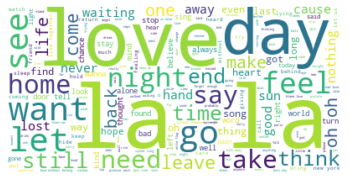

In [1227]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Split test and train

In [1019]:
df_full = pd.read_csv('full_bysong_clean.csv', sep='\t', index_col = [0])

In [1020]:
df_train, df_test = train_test_split(df_full, test_size=0.2, random_state = 30)

In [1021]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [1022]:
# y - 
labels = df_train['muse'].tolist()

In [1023]:
labels_test = df_test['muse'].tolist()

# Count vectorizer and TfidVectorizer

In [1024]:
vectorizer_tf = TfidfVectorizer(stop_words='english',
                                tokenizer = LemmaTokenizer(),
                                token_pattern = r'\b[a-zA-Z]{3,}\b')



In [1025]:
X_train_tf = vectorizer_tf.fit_transform(df_train['lyrics'])
X_test_tf = vectorizer_tf.transform(df_test['lyrics'])

/Users/ilonanietosvaara/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [1026]:
df_train_tf = pd.DataFrame(X_train_tf.toarray(), columns=vectorizer_tf.get_feature_names_out(), index=labels)
df_test_tf = pd.DataFrame(X_test_tf.toarray(), columns=vectorizer_tf.get_feature_names_out(), index=labels_test)



In [1027]:
df_train_tf.head(2)

,abandon,abd,abide,ablaze,able,absent,absolutely,absurd,abused,accept,...,youre,youth,youve,zeta,zigzag,árvore,é,ṗull,ṗunched,’
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.037563,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.054181,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1028]:
'''
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
'''

'\nclass LemmaTokenizer(object):\n    def __init__(self):\n        self.wnl = WordNetLemmatizer()\n    def __call__(self, articles):\n        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]\n'

In [1029]:
vectorizer = CountVectorizer(stop_words='english',
                            tokenizer = LemmaTokenizer(),
                            token_pattern = r'\b[a-zA-Z]{3,}\b', # keeps words of 3 or more characters
                            #ngram_range=(2,2)
                            max_df = 0.85) #ignore terms that have a document frequency strictly higher than the given threshold


In [1030]:
X_train = vectorizer.fit_transform(df_train['lyrics'].values.astype('U'))
X_test = vectorizer.transform(df_test['lyrics'].values.astype('U'))

/Users/ilonanietosvaara/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [1031]:
X_train.toarray(), X_test.toarray()

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [1032]:
df_train_count = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out(), index = labels)
df_test_count = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out(), index = labels_test)

In [1033]:
df_train_count.head(2)

,abandon,abd,abide,ablaze,able,absent,absolutely,absurd,abused,accept,...,youre,youth,youve,zeta,zigzag,árvore,é,ṗull,ṗunched,’
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [1034]:
df_train_count.shape, df_test_count.shape

((173, 2198), (44, 2198))

# Logistic regression

In [1035]:
# Transform labels to string in order to get the artist names (instead of 1 or 0)
output = [str(x) for x in labels]
output_test = [str(x) for x in labels_test]

In [1036]:
# Get data into 0.1 format 
artists = [w.replace('1', 'muse') for w in output]
artists = [w.replace('0', 'dido') for w in artists]

artists_test = [w.replace('1', 'muse') for w in output_test]
artists_test = [w.replace('0', 'dido') for w in artists_test]

In [1037]:
# Set variables
X = X_train.toarray()
y = labels

X_test = X_test.toarray()
y_test = labels_test

In [1038]:
# Fit model to train data
m = LogisticRegression(C=0.0001).fit(X, y)

**Hyperparameter C:** 

A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data.

In [1039]:
# Logistic model test scores
m.score(X,y), m.score(X_test, y_test)


(0.5838150289017341, 0.7045454545454546)

In [1040]:
# 1 = muse (--> bad prediction)
m.predict(vectorizer.transform(["sand shoes"]))

array([1])

In [1041]:
m.predict_proba(vectorizer.transform(["sand shoes"]))

array([[0.41046133, 0.58953867]])

In [1042]:
m.classes_

array([0, 1])

In [ ]:
print_evaluations(y, ypred_nb, "Naive Bayes")

# Random forest classification

In [1043]:
y = labels
#X = X_train.toarray()
y_test = labels_test
#X_test = X_test.toarray()

In [1048]:
len(X)

173

In [1052]:
depth = int(len(X)/3)

In [1053]:
depth

57

In [1054]:
rf_clf = RandomForestClassifier(max_depth=3,
                                max_features= depth,
                                random_state=10)

In [1055]:
rf_clf.fit(X, y)

RandomForestClassifier(max_depth=3, max_features=57, random_state=10)

In [1056]:
ypred_rf = rf_clf.predict(X)
y_test_pred_rf = rf_clf.predict(X_test)

In [1057]:
def print_evaluations(ytrue, ypred, model_name):
    print(f'Scores of the model {model_name}:')
    print(f'The accuracy of the model is: {round(accuracy_score(ytrue, ypred), 3)}')
    print(f'The precision of the model is: {round(precision_score(ytrue, ypred), 3)}')
    print(f'The recall of the model is: {round(recall_score(ytrue, ypred), 3)}')
    print(f'The f1-score of the model is: {round(f1_score(ytrue, ypred), 3)}')
    
    #print confusion matrix
    cm = confusion_matrix(ytrue, ypred)    
    disp = ConfusionMatrixDisplay(cm, display_labels=['dido', 'muse'])
    disp.plot()

Scores of the model Random Forest:
The accuracy of the model is: 0.867
The precision of the model is: 0.811
The recall of the model is: 1.0
The f1-score of the model is: 0.896


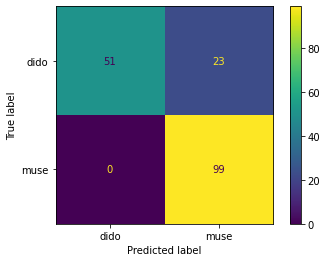

In [1058]:
print_evaluations(y, ypred_rf, "Random Forest")

Scores of the model Random Forest:
The accuracy of the model is: 0.795
The precision of the model is: 0.769
The recall of the model is: 1.0
The f1-score of the model is: 0.87


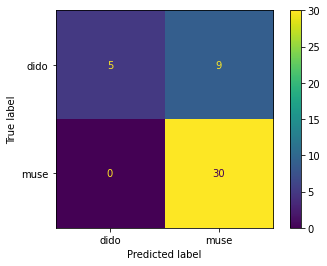

In [1059]:
print_evaluations(y_test, y_test_pred_rf, "Random Forest")

# Naive Bayes

In [1060]:
model = MultinomialNB()

In [1061]:
model.fit(X, artists)

MultinomialNB()

In [1062]:
model.score(X, artists), model.score(X_test, artists_test)

(0.976878612716763, 0.8181818181818182)

In [1063]:
new_lyrics = ["I will take your innocence", "sand in the space"]

In [1064]:
new_vectors = vectorizer.transform(new_lyrics)

In [1065]:
model.predict(new_vectors)

array(['muse', 'muse'], dtype='<U4')

In [1066]:
model.predict_proba(new_vectors)

array([[0.14160187, 0.85839813],
       [0.38548149, 0.61451851]])

In [1067]:
ypred_nb = model.predict(X)
y_test_pred_nb = model.predict(X_test)

# Class imbalance - not needed - data more or less balanced (57/ 43)